     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 4.8 MB/s eta 0:00:00


(0.0, 40.0)

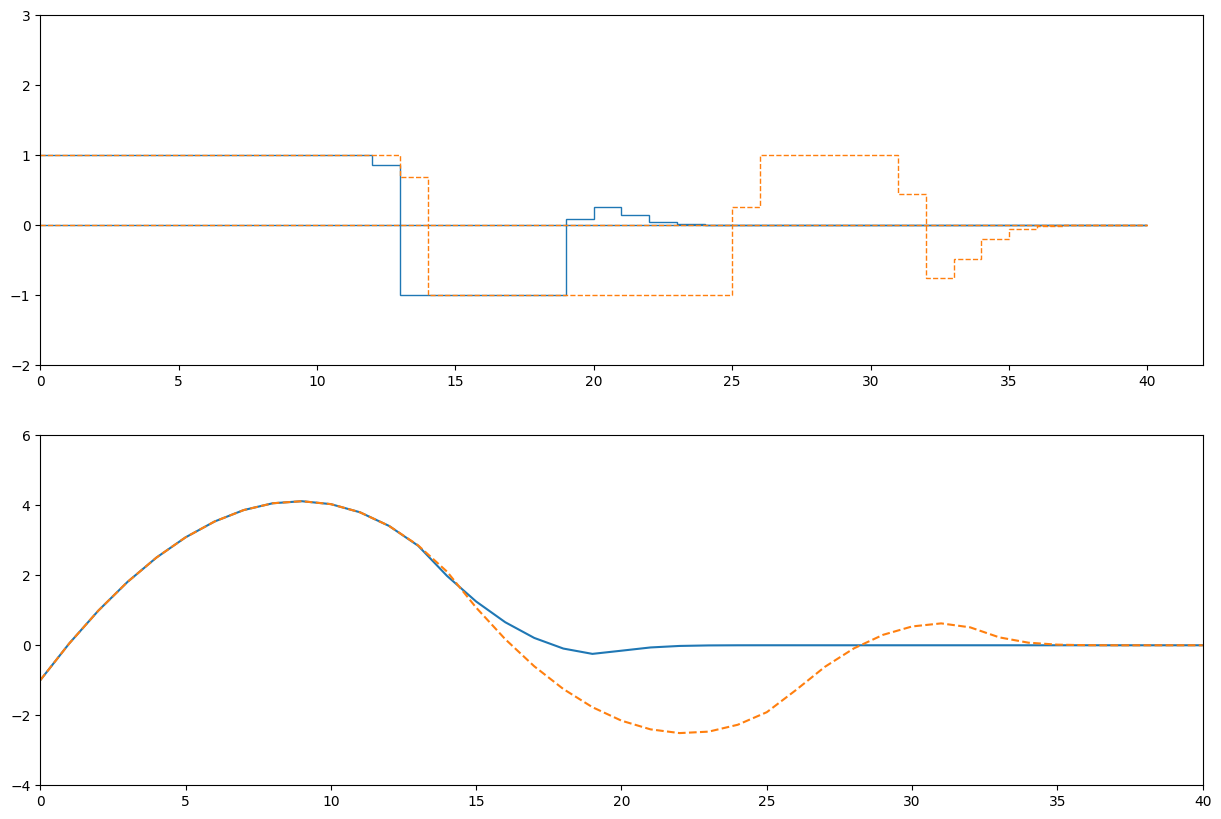

In [2]:
# We run the code presented in:

#  https://it.mathworks.com/help/mpc/ug/solve-custom-mpc-quadratic-programming-problem-and-generate-code.html

#  explained in page 12 of the "Lecture notes" by Professor Mark Cannon's lecture notes for the Model Predictive
#       Control class at University of Oxford

#  https://markcannon.github.io/assets/downloads/teaching/C21_Model_Predictive_Control/C21_MPC_Lecture_Notes.pdf


!pip install control
import control as ctrl
from scipy.linalg import solve_discrete_lyapunov
import cvxpy as cp
import numpy as np
# Define system matrices
A = np.array([[1.1, 2], [0, 0.95]])
B = np.array([[0], [0.0787]])
C = np.array([[-1, 1]])
D = np.array([[0]])
Ts = 1
# Define initial state
x0 = np.array([[0.5], [-0.5]])
Qy = np.array([[1]]);  R = np.array([[0.01]])
# Create state-space system
sys = ctrl.ss(A, B, C, D, Ts);Qb = np.dot(np.dot(C.T, Qy), C);Rb = np.dot(np.dot(D.T, Qy), D) + R
Nb = np.dot(np.dot(C.T, Qy), D)
K, _, _ = ctrl.lqr(sys, Qb, Rb);   K=-K
t = np.arange(0, 41);  lt = len(t)

x = x0
Y_lqr = np.zeros(lt);U_lqr = np.zeros(lt)
for i in range(lt):
    Y_lqr[i] = np.dot(C, x)
    u = np.dot(K, x) ;    u = max(-1, min(1, u))
    U_lqr[i] = u ;     x = np.dot(A, x) + np.dot(B, u)

Q = np.dot(C.T, C)
AA = (A + np.dot(B, K)).T
QQ = Q + np.dot(K.T, np.dot(R, K))
Q_bar = solve_discrete_lyapunov(AA, QQ)  #----- solve Lyapunov equation

n = A.shape[0];m = B.shape[1] ;l = C.shape[0]
N = 16  # Horizon
# Formula (2.2) page 16
M = np.zeros((N * n, n))
for i in range(1, N + 1):
    M[(i - 1) * n:i * n, :] = np.linalg.matrix_power(A, i)

CONV = np.zeros((N * n, N * m))
for i in range(1, N + 1):
    for j in range(1, i + 1):
        CONV[(i - 1) * n:i * n, (j - 1) * m:j * m] = np.linalg.matrix_power(A, (i - j)).dot(B)

# Formula at page 17
Q_hat = np.zeros((n * N, n * N))
for i in range(1, N):
    Q_hat[(i - 1) * n:i * n, (i - 1) * n:i * n] = Q
Q_hat[(N - 1) * n:N * n, (N - 1) * n:N * n] = Q_bar

R_hat = np.zeros((l * N, l * N))
for i in range(1, N + 1):
    R_hat[(i - 1) * l:i * l, (i - 1) * l:i * l] = R

# Formula (2.4) page 17
H = np.dot(CONV.T, np.dot(Q_hat, CONV)) + R_hat
F = np.dot(CONV.T, np.dot(Q_hat, M))

H = (H + H.T) / 2

lt = len(t) ;  l = C.shape[0] ;m = B.shape[1]
Ac = np.vstack([np.eye(N), -np.eye(N)])
b0 = np.ones(2 * N)
x = x0; Y_MPC = np.zeros(lt);   U_MPC = np.zeros(lt)

#---- this is a main loop in which several QPs are being solved
for ct in range(lt):
    Y_MPC[ct] = C.dot(x)
    xx = cp.Variable(N)
    q=F.dot(x)
    prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(xx, H) + q.T @ xx),[Ac @ xx <= b0])
    prob.solve()
    u=xx.value
    u = u[:m].reshape(-1, 1)
    U_MPC[ct] = u[0]
    x = np.dot(A,x) + np.dot(B,u)

import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.stairs(range(1,41),U_MPC, orientation='horizontal')
plt.stairs(range(1,41),U_lqr, linestyle='--', orientation='horizontal')
plt.ylim([-2,3])
plt.subplot(2, 1, 2)
plt.plot(t,Y_MPC)
plt.plot(t,Y_lqr, '--')
plt.ylim([-4, 6])
plt.xlim([0, 40])
